In [119]:
import pandas as pd
import numpy as np
from tabulate import tabulate
from scipy import stats
import matplotlib.pyplot as plt

# import statmodels
import statsmodels.formula.api as smf
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.graphics.factorplots import interaction_plot
import statsmodels.api as sm
import seaborn as sns

#### Some utulity functions

In [21]:
def create_2cat_table(data, cat_var1, cat_var2, observation):
    '''
    cerate tables for anova observation
    input: 
        data: dataset type of panda dataframe
        cat_var1: label of first cat variable
        cat_var2: label of second cat variable
        observation: label of traget variable
        
    
    '''
    
    # list for storing tabulate data
    tabulate_list = []

    # iterate over first var
    for cat_1 in np.unique(data[cat_var1]):

        sub_group=''
        sub_len=''
        sub_mean=''
        sub_std=''

        # iterate over second var
        for cat_2 in np.unique(data[cat_var2]):

            # get value for given cat_1 and cat_2
            tmp_data = data[(data[cat_var1]==cat_1) & (data[cat_var2]==cat_2)][observation]

            # labels
            sub_group=sub_group+'\n'+cat_2
            
            # values
            sub_len=sub_len+'\n'+str(len(tmp_data))
            sub_mean=sub_mean+'\n'+ '%.2f' % np.mean(tmp_data)
            sub_std=sub_std+'\n'+ '%.2f' % np.std(tmp_data)

        # add to main tabulate list
        tabulate_list.append([cat_1, sub_group, sub_len, sub_mean, sub_std,
                             np.mean(data[data[cat_var1]==cat_1][observation]),
                             np.std(data[data[cat_var1]==cat_1][observation])])

    # print tabulate
    print(tabulate(tabulate_list, headers=[cat_var1, cat_var2, 'N', 
                                        observation+'\nmean', 
                                        observation+'\nstd',
                                        observation+'\nmean_all', 
                                        observation+'\nstd_all'], tablefmt='grid'))

In [22]:
def create_1cat_table(data, cat_var1, observation):
    '''
    cerate tables for anova observation
    input: 
        data: dataset type of panda dataframe
        cat_var1: label of first cat variabl
        observation: label of traget variable
    '''
    
    # list for storing tabulate data
    tabulate_list = []

    # iterate over first var
    for cat_1 in np.unique(data[cat_var1]):
     
        # get value for given cat_1 and cat_2
        tmp_data = data[data[cat_var1]==cat_1][observation]

        # add to main tabulate list
        tabulate_list.append([cat_1, len(tmp_data), 
                              '%.2f' % np.mean(tmp_data),
                              '%.2f' % np.std(tmp_data)])

    # print tabulate
    print(tabulate(tabulate_list, headers=[cat_var1, 'N', 
                                        observation+'\nmean', 
                                        observation+'\nstd'], tablefmt='grid'))

In [44]:
def independence_test(lm):
    '''
    gets fitted lm model and plot residuals vs fitted valuesfor checking
    independence
    '''
    
    fig = plt.figure()

    fig.axes[0] = sns.residplot(lm.fittedvalues, lm.resid,
                          lowess=True,
                          scatter_kws={'alpha': 0.5},
                          line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})

    fig.axes[0].set_title('Residuals vs Fitted')
    fig.axes[0].set_xlabel('Fitted values')
    fig.axes[0].set_ylabel('Residuals')

## Load data

In [2]:
# load data
data = pd.read_csv ('Dataset_heart rate_retail stores.csv')

data.columns

Index(['Id', 'age', 'gender', 'BMI', 'sleeping_time',
       'sporting_activity_(h/week)', 'daytime', 'outdoor_temperature',
       'shopping_cart', 'attendants', 'shopping_frequency', 'cash_point',
       'shopping_amount', 'weekday', 'smoking', 'ex_max', 'ex_min', 'hr_max',
       'max_time', 'hr_min', 'min_time', 'shopping duration (in minutes)',
       'reaching HRmax'],
      dtype='object')

In [3]:
# raname shopping duration (in minutes) for easy handling
data=data.rename(columns = {'shopping duration (in minutes)':'shop_dur'})

## Create categorical vars

For doing ANOVA test, we need some group variable. Here we'll create new categorical variables from exsisting onee for this purpose.

#### But fist remove the siginificant outliers in shoping durations

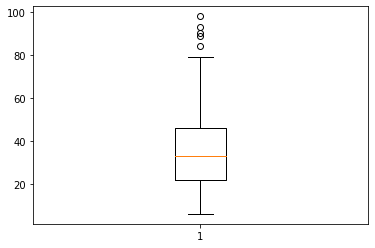

In [4]:
plt.boxplot(x=data['shop_dur'])
plt.show()

In [5]:
Q1 = data['shop_dur'].quantile(0.25)
Q3 = data['shop_dur'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

In [6]:
data[(data['shop_dur']<lower_bound) | (data['shop_dur']>upper_bound)]['shop_dur']

17     90
25     89
96     84
120    98
121    93
Name: shop_dur, dtype: int64

In [7]:
data.drop(data[(data['shop_dur'] > upper_bound) | (data['shop_dur'] < lower_bound) ].index , inplace=True)

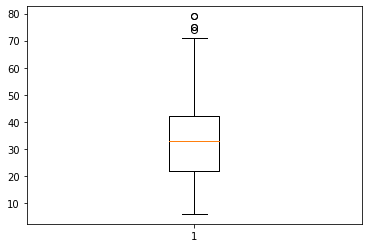

In [8]:
plt.boxplot(x=data['shop_dur'])
plt.show()

### Categorize varaibles

For dviding varaibles in to the groups we'll use qcut from panda which is *Quantile-based discretization function*. This basically means that qcut tries to divide up the underlying data into equal sized bins. 

#### 1. for age grops

In [9]:
# make new categorical data
data['age_groups'] = pd.qcut(data['age'], q=4)

# factor data
data['age_groups'] = data['age_groups'].astype(str)

data['age_groups'].value_counts()

(29.0, 40.0]      44
(17.999, 29.0]    41
(52.0, 72.0]      38
(40.0, 52.0]      37
Name: age_groups, dtype: int64

#### 2. for outdoor_temperature

In [10]:
# make new categorical data
data['out_t_groups'] = pd.qcut(data['outdoor_temperature'], q=4)

# factorize data
data['out_t_groups'] = data['out_t_groups'].astype(str)

data['out_t_groups'].value_counts()

(11.999, 18.0]    49
(21.0, 23.0]      38
(23.0, 28.0]      38
(18.0, 21.0]      35
Name: out_t_groups, dtype: int64

#### 3. for sporting_activity_(h/week)

In [11]:
# make new categorical data
data['sport_activity_groups'] = pd.qcut(data['sporting_activity_(h/week)'], q=4)

# factorize data
data['sport_activity_groups'] = data['sport_activity_groups'].astype(str)

data['sport_activity_groups'].value_counts()

(-0.001, 1.0]    54
(2.0, 4.0]       42
(4.0, 14.0]      36
(1.0, 2.0]       28
Name: sport_activity_groups, dtype: int64

#### 4. for sleeping_time

In [12]:
# make new categorical data
data['sleeping_time_groups'] = pd.qcut(data['sleeping_time'], q=4)

# factorize data
data['sleeping_time_groups'] = data['sleeping_time_groups'].astype(str)

data['sleeping_time_groups'].value_counts()

(7.0, 8.0]      50
(6.0, 7.0]      47
(2.999, 6.0]    41
(8.0, 12.0]     22
Name: sleeping_time_groups, dtype: int64

#### 5. for ex_max

In [13]:
# make new categorical data
data['ex_max_groups'] = pd.qcut(data['ex_max'], q=4)

# factorize data
data['ex_max_groups'] = data['ex_max_groups'].astype(str)

data['ex_max_groups'].value_counts()

(106.0, 116.0]     41
(69.999, 106.0]    41
(124.25, 148.0]    40
(116.0, 124.25]    38
Name: ex_max_groups, dtype: int64

#### 6. for ex_min

In [14]:
# make new categorical data
data['ex_min_groups'] = pd.qcut(data['ex_min'], q=4)

# factorize data
data['ex_min_groups'] = data['ex_min_groups'].astype(str)

data['ex_min_groups'].value_counts()

(43.999, 65.0]    44
(80.25, 120.0]    40
(72.0, 80.25]     38
(65.0, 72.0]      38
Name: ex_min_groups, dtype: int64

#### 7. for max_time

In [15]:
# make new categorical data
data['max_time_groups'] = pd.qcut(data['max_time'], q=4)

# factorize data
data['max_time_groups'] = data['max_time_groups'].astype(str)

data['max_time_groups'].value_counts()

(0.999, 8.0]    43
(16.5, 31.0]    41
(31.0, 74.0]    39
(8.0, 16.5]     37
Name: max_time_groups, dtype: int64

#### 8. for max_time

In [16]:
# make new categorical data
data['min_time_groups'] = pd.qcut(data['min_time'], q=4)

# factorize data
data['min_time_groups'] = data['min_time_groups'].astype(str)

data['min_time_groups'].value_counts()

(0.999, 6.0]     43
(13.0, 23.0]     42
(6.0, 13.0]      38
(23.0, 150.0]    37
Name: min_time_groups, dtype: int64

#### Check the distribution of traget data

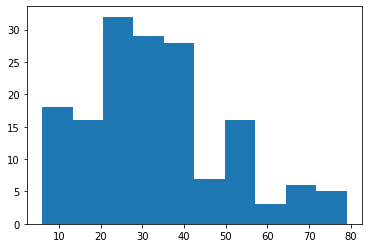

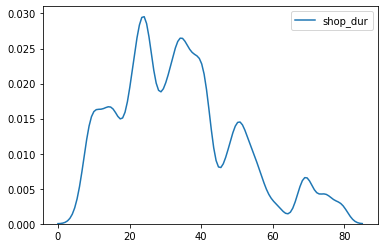

In [18]:
plt.hist(data['shop_dur'])
plt.show()

sns.kdeplot(data['shop_dur'], cumulative=False, bw=2)

In [17]:
data.head()

,Id,age,gender,BMI,sleeping_time,sporting_activity_(h/week),daytime,outdoor_temperature,shopping_cart,attendants,...,shop_dur,reaching HRmax,age_groups,out_t_groups,sport_activity_groups,sleeping_time_groups,ex_max_groups,ex_min_groups,max_time_groups,min_time_groups
0,1,55,female,30.0,7.0,2.0,noon,23,no,no,...,12,0,"(52.0, 72.0]","(21.0, 23.0]","(1.0, 2.0]","(6.0, 7.0]","(106.0, 116.0]","(65.0, 72.0]","(0.999, 8.0]","(0.999, 6.0]"
1,2,25,female,18.4,9.0,1.0,noon,23,yes,no,...,26,0,"(17.999, 29.0]","(21.0, 23.0]","(-0.001, 1.0]","(8.0, 12.0]","(106.0, 116.0]","(80.25, 120.0]","(16.5, 31.0]","(13.0, 23.0]"
2,3,38,male,25.1,5.0,3.0,noon,23,no,no,...,24,0,"(29.0, 40.0]","(21.0, 23.0]","(2.0, 4.0]","(2.999, 6.0]","(106.0, 116.0]","(72.0, 80.25]","(16.5, 31.0]","(13.0, 23.0]"
3,4,21,female,22.6,8.0,0.0,evening,23,yes,family,...,46,0,"(17.999, 29.0]","(21.0, 23.0]","(-0.001, 1.0]","(7.0, 8.0]","(124.25, 148.0]","(43.999, 65.0]","(16.5, 31.0]","(23.0, 150.0]"
4,5,30,female,21.7,12.0,10.0,evening,23,yes,life partner,...,41,1,"(29.0, 40.0]","(21.0, 23.0]","(4.0, 14.0]","(8.0, 12.0]","(106.0, 116.0]","(43.999, 65.0]","(31.0, 74.0]","(13.0, 23.0]"


## ANOVA assumption

Here we'll carry out various ANOVA tests on different group values. Moreover, we'll also try to make some inferences based on ANOVA test.

# 1. shop_dur ~ age_groups + gender + age_groups*gender 

In [66]:
create_2cat_table(data, 'age_groups', 'gender', 'shop_dur')

+----------------+----------+-----+------------+------------+------------+------------+
| age_groups     | gender   | N   | shop_dur   | shop_dur   |   shop_dur |   shop_dur |
|                |          |     | mean       | std        |   mean_all |    std_all |
+================+==========+=====+============+============+============+============+
| (17.999, 29.0] | female   | 22  | 39.91      | 20.65      |    38.3171 |    19.7255 |
|                | male     | 19  | 36.47      | 18.42      |            |            |
+----------------+----------+-----+------------+------------+------------+------------+
| (29.0, 40.0]   | female   | 22  | 33.27      | 16.29      |    33.2727 |    15.7197 |
|                | male     | 22  | 33.27      | 15.13      |            |            |
+----------------+----------+-----+------------+------------+------------+------------+
| (40.0, 52.0]   | female   | 22  | 34.45      | 15.41      |    31.6757 |    14.5566 |
|                | male     | 15

In [67]:
lm = smf.ols('shop_dur ~ age_groups + gender + age_groups*gender', data=data).fit()

### Independence of varaibles and homogenity

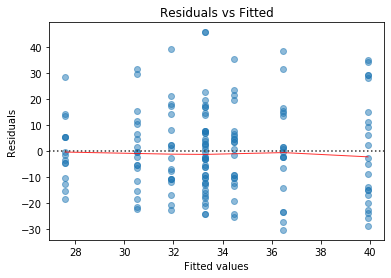

In [68]:
independence_test(lm)

This plot shows the residuals (errors) on the y-axis and the fitted values (predicted values) on the x-axis. We can see that plot has no pattern or in other words each goup has same variance, thus the points should look like a more of random points. The plot spoints out that the variances are approximately homogenous since the residuals are distributed approximately equally above and below zero.

### Shaprio-Wild test//qq plot to check the normal distribution of residuals

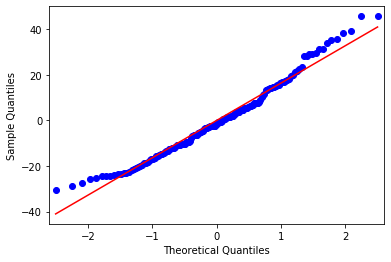

In [70]:
fig = sm.qqplot(lm.resid, line='s')
plt.show()

In [69]:
_, p = stats.shapiro(lm.resid)
print('p-values %.4f' % p)

p-values 0.0033


As the p-value < 0.0033 is non-significant, we fail to reject null hypothesis and conclude that residuals are normally distributed.

### Calculate anova

As the assumptions of anova meet, now we can calculate it.

In [73]:
sm.stats.anova_lm(lm, type=2)

,df,sum_sq,mean_sq,F,PR(>F)
age_groups,3.0,1269.164531,423.054844,1.493336,0.218647
gender,1.0,174.572109,174.572109,0.616220,0.433677
age_groups:gender,3.0,382.593952,127.531317,0.450171,0.717542
Residual,152.0,43060.863158,283.295152,NaN,NaN


As we can see from the PR(>F) values, n-Anova test doesn't suggest a significant difference between the effects of age_groups and gender on shopping duration. Also, we can see from the interaction term that the interaction of given factors don't have a significant effect on the response var. 

#### Interaction plot

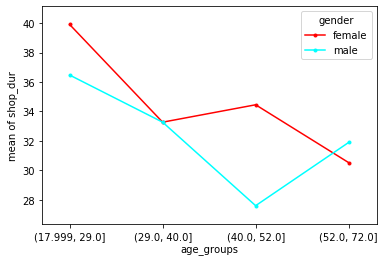

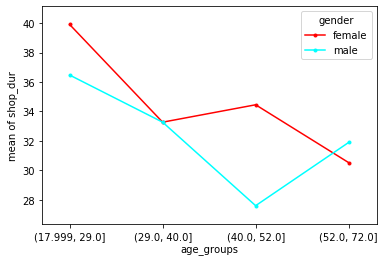

In [65]:
interaction_plot(data['age_groups'], data['gender'], data['shop_dur'])

Although general interaction is not significant, we can still see the relatively some difference between genders on [54, 52] age groups. This explains that female customers of this age grup spend more time in shopping and they have an impact on the males shopping duration.

## 2. shop_dur ~ age_groups

In [94]:
create_1cat_table(data, 'age_groups', 'shop_dur')

+----------------+-----+------------+------------+
| age_groups     |   N |   shop_dur |   shop_dur |
|                |     |       mean |        std |
+================+=====+============+============+
| (17.999, 29.0] |  41 |      38.32 |      19.73 |
+----------------+-----+------------+------------+
| (29.0, 40.0]   |  44 |      33.27 |      15.72 |
+----------------+-----+------------+------------+
| (40.0, 52.0]   |  37 |      31.68 |      14.56 |
+----------------+-----+------------+------------+
| (52.0, 72.0]   |  38 |      31.21 |      15.35 |
+----------------+-----+------------+------------+


In [95]:
lm = smf.ols('shop_dur ~ age_groups', data=data).fit()

### Independence of varaibles

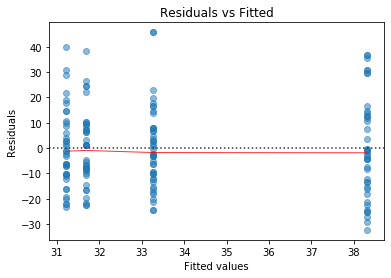

In [96]:
independence_test(lm)

This plot shows the residuals (errors) on the y-axis and the fitted values (predicted values) on the x-axis. We can see that plot is randomly distributed, this is independent.

### Homogenity test

In [97]:
groups = np.unique(data['age_groups'])
print(groups)

['(17.999, 29.0]' '(29.0, 40.0]' '(40.0, 52.0]' '(52.0, 72.0]']


In [99]:
w, pvalue = stats.bartlett(data[data['age_groups']==groups[0]]['shop_dur'], 
                           data[data['age_groups']==groups[1]]['shop_dur'], 
                           data[data['age_groups']==groups[2]]['shop_dur'], 
                           data[data['age_groups']==groups[3]]['shop_dur'])
print('p-values %.4f' % p)

p-values 0.0026


As the p-value < 0.0026 is non significant, we fail to reject null hypothesis and conclude that treatments have equal variances.

### Shaprio-Wild//qq plot test to check the normal distribution of residuals

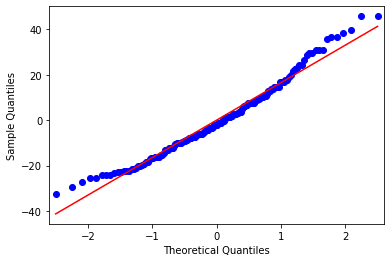

In [91]:
fig = sm.qqplot(lm.resid, line='s')
plt.show()

In [92]:
_, p = stats.shapiro(lm.resid)
print('p-values %.4f' % p)

p-values 0.0026


As the p-value < 0.0026 is non significant, we fail to reject null hypothesis and conclude that residuals are normally distributed.

## Calculate annova

As the assumptions of anova meet, now we can calculate it.

In [232]:
sm.stats.anova_lm(lm, type=1)

,df,sum_sq,mean_sq,F,PR(>F)
age_groups,3.0,1269.164531,423.054844,1.513057,0.213305
Residual,156.0,43618.029219,279.602751,NaN,NaN


We don't find a significant main effect of age groups (F = 1.51, p > .21) on shopping durations.

## 3. shop_dur ~ out_t_groups

In [108]:
create_1cat_table(data, 'out_t_groups', 'shop_dur')

+----------------+-----+------------+------------+
| out_t_groups   |   N |   shop_dur |   shop_dur |
|                |     |       mean |        std |
+================+=====+============+============+
| (11.999, 18.0] |  49 |      41.04 |      18.35 |
+----------------+-----+------------+------------+
| (18.0, 21.0]   |  35 |      29.69 |      16.01 |
+----------------+-----+------------+------------+
| (21.0, 23.0]   |  38 |      28.5  |      13.78 |
+----------------+-----+------------+------------+
| (23.0, 28.0]   |  38 |      33.16 |      14.46 |
+----------------+-----+------------+------------+


In [109]:
lm = smf.ols('shop_dur ~ out_t_groups', data=data).fit()

### Independence of varaibles

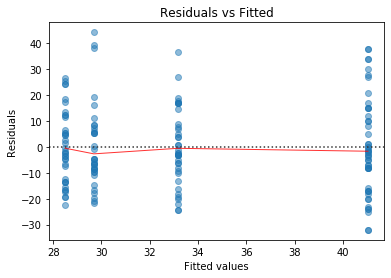

In [110]:
independence_test(lm)

This plot shows the residuals (errors) on the y-axis and the fitted values (predicted values) on the x-axis. We can see that plot is randomly distributed, this is independent.

### Homogenity test

In [111]:
groups = np.unique(data['out_t_groups'])
print(groups)

['(11.999, 18.0]' '(18.0, 21.0]' '(21.0, 23.0]' '(23.0, 28.0]']


In [112]:
w, pvalue = stats.bartlett(data[data['out_t_groups']==groups[0]]['shop_dur'], 
                           data[data['out_t_groups']==groups[1]]['shop_dur'], 
                           data[data['out_t_groups']==groups[2]]['shop_dur'], 
                           data[data['out_t_groups']==groups[3]]['shop_dur'])
print('p-values %.4f' % p)

p-values 0.0026


As the p-value < 0.0026 is non significant, we fail to reject null hypothesis and conclude that treatments have equal variances.

### Shaprio-Wild//qq plot test to check the normal distribution of residuals

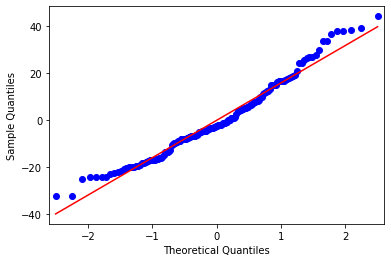

In [113]:
fig = sm.qqplot(lm.resid, line='s')
plt.show()

In [114]:
_, p = stats.shapiro(lm.resid)
print('p-values %.4f' % p)

p-values 0.0016


The p-value < 0.0016 is non significant, we fail to reject null hypothesis and conclude that residuals are normally distributed.

### Calculate anova

As the assumptions of anova meet, now we can calculate it.

In [115]:
sm.stats.anova_lm(lm, type=1)

,df,sum_sq,mean_sq,F,PR(>F)
out_t_groups,3.0,4243.179894,1414.393298,5.428729,0.001409
Residual,156.0,40644.013856,260.538550,NaN,NaN


As it's also clear from the table, the ANOVA test suggests us that response of temperature groups on shopping duration is important where  (F = 4.42, p < 0.0014).

### Tukey HSD test

As the ANOVA tels that effect of temperature groups on shopping groups differs significanly. Now using Tukey HSD we can find which groups are significantly different from each other

In [122]:
print(pairwise_tukeyhsd(data['shop_dur'], data['out_t_groups'], alpha=0.05))

        Multiple Comparison of Means - Tukey HSD, FWER=0.05        
    group1        group2    meandiff p-adj   lower    upper  reject
-------------------------------------------------------------------
(11.999, 18.0] (18.0, 21.0] -11.3551 0.0096 -20.6326 -2.0776   True
(11.999, 18.0] (21.0, 23.0] -12.5408 0.0024 -21.6022 -3.4794   True
(11.999, 18.0] (23.0, 28.0]  -7.8829 0.1123 -16.9443  1.1785  False
  (18.0, 21.0] (21.0, 23.0]  -1.1857    0.9 -11.0068  8.6354  False
  (18.0, 21.0] (23.0, 28.0]   3.4722 0.7704  -6.3489 13.2933  False
  (21.0, 23.0] (23.0, 28.0]   4.6579 0.5804  -4.9593 14.2751  False
-------------------------------------------------------------------


We can see that (11.999, 18.0] and (18.0, 21.0] temperature groups suggest statistically significant differences. This helps us to come to the conclusion that people often go shopping during the cool days.

## 4. shop_dur ~  out_t_groups + gender + out_t_groups*gender

In [149]:
create_2cat_table(data, 'out_t_groups', 'age_groups', 'shop_dur')

+----------------+----------------+-----+------------+------------+------------+------------+
| out_t_groups   | age_groups     | N   | shop_dur   | shop_dur   |   shop_dur |   shop_dur |
|                |                |     | mean       | std        |   mean_all |    std_all |
+================+================+=====+============+============+============+============+
| (11.999, 18.0] | (17.999, 29.0] | 15  | 40.80      | 21.39      |    41.0408 |    18.3514 |
|                | (29.0, 40.0]   | 13  | 38.46      | 21.58      |            |            |
|                | (40.0, 52.0]   | 11  | 39.82      | 11.90      |            |            |
|                | (52.0, 72.0]   | 10  | 46.10      | 12.92      |            |            |
+----------------+----------------+-----+------------+------------+------------+------------+
| (18.0, 21.0]   | (17.999, 29.0] | 8   | 49.38      | 17.40      |    29.6857 |    16.0121 |
|                | (29.0, 40.0]   | 6   | 25.67      | 9.69 

In [129]:
lm = smf.ols('shop_dur ~ out_t_groups + age_groups + out_t_groups*age_groups ', data=data).fit()

### Independence of varaibles and homogenity

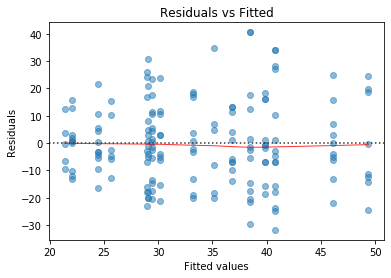

In [130]:
independence_test(lm)

We can see that plot has no pattern or in other words each goup has same variance, thus the points should look like a more of random points. The plot spoints out that the variances are approximately homogenous since the residuals are distributed approximately equally above and below zero.

### Shaprio-Wild test//qq plot to check the normal distribution of residuals

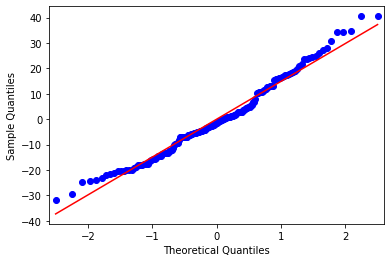

In [131]:
fig = sm.qqplot(lm.resid, line='s')
plt.show()

In [132]:
_, p = stats.shapiro(lm.resid)
print('p-values %.4f' % p)

p-values 0.0140


As the p-value < 0.014 is non-significant, we fail to reject null hypothesis and conclude that residuals are normally distributed.

### Calculate anova

As the assumptions of anova meet, now we can calculate it.

In [133]:
sm.stats.anova_lm(lm, type=2)

,df,sum_sq,mean_sq,F,PR(>F)
out_t_groups,3.0,4243.179894,1414.393298,5.728143,0.000989
age_groups,3.0,938.944615,312.981538,1.267542,0.287836
out_t_groups:age_groups,9.0,4148.583169,460.953685,1.866814,0.061422
Residual,144.0,35556.486072,246.920042,NaN,NaN


#### Interaction plot

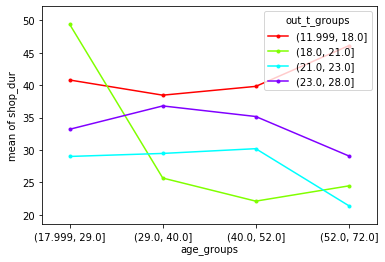

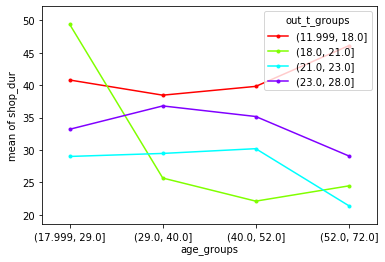

In [134]:
interaction_plot(data['age_groups'], data['out_t_groups'], data['shop_dur'])

Interaction between outdoor temperature groups and age groups is not significant, but close to rejection interval (F > 0.06). As it's clear from the above plot, it's that still can be important for capturing some pattern on customer behaviour. From the interaction plot, we can see temperature has a relatively same affec effect on middle age customer's behaviours. Where here it's shows different effect on among old (17, 29] and (52, 72] age groups.  

## 5. shop_dur ~ attendants

In [137]:
create_1cat_table(data, 'attendants', 'shop_dur')

+---------------+-----+------------+------------+
| attendants    |   N |   shop_dur |   shop_dur |
|               |     |       mean |        std |
+===============+=====+============+============+
| family        |  11 |      38.64 |      15.33 |
+---------------+-----+------------+------------+
| family member |  13 |      32.62 |      13.81 |
+---------------+-----+------------+------------+
| life partner  |  53 |      43.43 |      16.62 |
+---------------+-----+------------+------------+
| little child  |   6 |      38.83 |      12.88 |
+---------------+-----+------------+------------+
| no            |  77 |      26.09 |      13.61 |
+---------------+-----+------------+------------+


In [138]:
lm = smf.ols('shop_dur ~ attendants', data=data).fit()

### Independence of varaibles

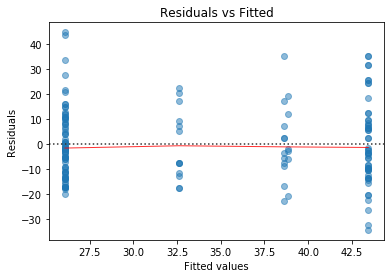

In [140]:
independence_test(lm)

This plot shows the residuals (errors) on the y-axis and the fitted values (predicted values) on the x-axis. We can see that plot is randomly distributed, this is independent.

### Homogenity test

In [142]:
groups = np.unique(data['attendants'])
print(groups)

['family' 'family member' 'life partner' 'little child' 'no']


In [150]:
w, pvalue = stats.bartlett(data[data['attendants']==groups[0]]['shop_dur'], 
                           data[data['attendants']==groups[1]]['shop_dur'], 
                           data[data['attendants']==groups[2]]['shop_dur'], 
                           data[data['attendants']==groups[3]]['shop_dur'],
                           data[data['attendants']==groups[4]]['shop_dur'])
print('p-values %.4f' % p)

p-values 0.0011


As the p-value < 0.011 is non significant, we fail to reject null hypothesis and conclude that treatments have equal variances.

### Shaprio-Wild//qq plot test to check the normal distribution of residuals

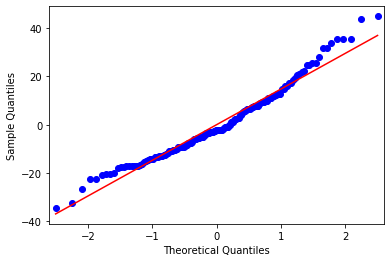

In [144]:
fig = sm.qqplot(lm.resid, line='s')
plt.show()

In [145]:
_, p = stats.shapiro(lm.resid)
print('p-values %.4f' % p)

p-values 0.0011


As the p-value < 0.0011 is non significant, we fail to reject null hypothesis and conclude that residuals are normally distributed.

### Calculate anova

Met assumptions now let us carry out ANOVA test

In [146]:
sm.stats.anova_lm(lm, type=2)

,df,sum_sq,mean_sq,F,PR(>F)
attendants,4.0,9921.355535,2480.338884,10.99509,7.100787e-08
Residual,155.0,34965.838215,225.586053,NaN,NaN


Having F < 0.000001, ANOVA test shows us that shopping duration upon attendants varies significantly from each other. We can also see from the table that, people spend more time on shopping when they're with family or life partner than they're alone. 

## 6. shop_dur ~ shopping_cart

In [147]:
create_1cat_table(data, 'shopping_cart', 'shop_dur')

+-----------------+-----+------------+------------+
| shopping_cart   |   N |   shop_dur |   shop_dur |
|                 |     |       mean |        std |
+=================+=====+============+============+
| no              |  65 |      24.42 |      13.12 |
+-----------------+-----+------------+------------+
| yes             |  95 |      40.06 |      15.98 |
+-----------------+-----+------------+------------+


In [148]:
lm = smf.ols('shop_dur ~ shopping_cart', data=data).fit()

### Independence of varaibles

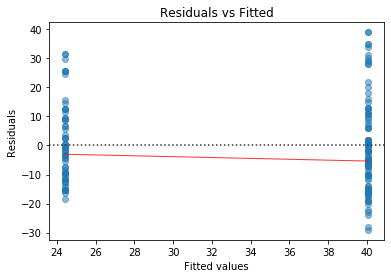

In [149]:
independence_test(lm)

This plot shows the residuals (errors) on the y-axis and the fitted values (predicted values) on the x-axis. Although there is a slope slightly leaning to the right, it's enough conclude that plot is randomly distributed, this is independent.

### Homogenity test

In [152]:
w, pvalue = stats.bartlett(data[data['shopping_cart']=='yes']['shop_dur'], 
                           data[data['shopping_cart']=='no']['shop_dur'])
print('p-values %.4f' % p)

p-values 0.0011


As the p-value < 0.0011 is non significant, we fail to reject null hypothesis and conclude that treatments have equal variances.

### Shaprio-Wild//qq plot test to check the normal distribution of residuals

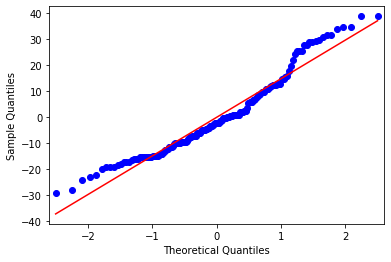

In [155]:
fig = sm.qqplot(lm.resid, line='s')
plt.show()

In [157]:
_, p = stats.shapiro(lm.resid)
print('p-values %.6f' % p)

p-values 0.000016


As the p-value is non significant, we fail to reject null hypothesis and conclude that residuals are normally distributed.

### Calculate anova

All the assumptions meet, no we're good to go!

In [158]:
sm.stats.anova_lm(lm, type=1)

,df,sum_sq,mean_sq,F,PR(>F)
shopping_cart,1.0,9449.788082,9449.788082,42.132501,1.048199e-09
Residual,158.0,35437.405668,224.287378,NaN,NaN


Here we can see that the null hypothesis is externally week. This suggests that taking a shopping cart on shopping definitely increase the duration of time a customer spends on shopping. This can be an important insight for markets on finding ways to increase the time customer spend on shopping, thus spend more money. 

## 7. shop_dur ~ smoking

In [171]:
create_1cat_table(data, 'smoking', 'shop_dur')

+-----------+-----+------------+------------+
|   smoking |   N |   shop_dur |   shop_dur |
|           |     |       mean |        std |
+===========+=====+============+============+
|         0 |  99 |      35.16 |      17.26 |
+-----------+-----+------------+------------+
|         1 |  61 |      31.34 |      15.61 |
+-----------+-----+------------+------------+


In [172]:
lm = smf.ols('shop_dur ~ smoking', data=data).fit()

### Independence of varaibles

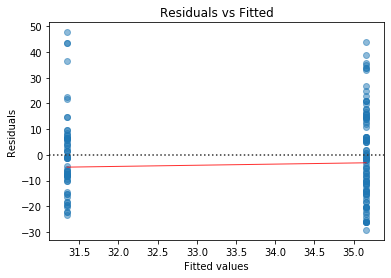

In [173]:
independence_test(lm)

From the plot, we can see that independece of variables holds.

### Homogenity test

In [174]:
w, pvalue = stats.bartlett(data[data['smoking']==0]['shop_dur'], 
                           data[data['smoking']==1]['shop_dur'])
print('p-values %.6f' % p)

p-values 0.000290


AS the p-value is non-significant, thus, homogenity holds.

### Shaprio-Wild//qq plot test to check the normal distribution of residuals

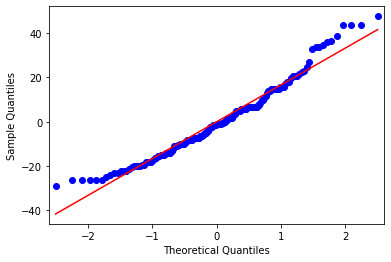

In [175]:
fig = sm.qqplot(lm.resid, line='s')
plt.show()

In [176]:
_, p = stats.shapiro(lm.resid)
print('p-values %.4f' % p)

p-values 0.0003


As the p-value < 0.003 is non significant, we fail to reject null hypothesis and conclude that residuals are normally distributed.

#### Calculate anova

In [177]:
sm.stats.anova_lm(lm, type=1)

,df,sum_sq,mean_sq,F,PR(>F)
smoking,1.0,550.009117,550.009117,1.960013,0.163472
Residual,158.0,44337.184633,280.615093,NaN,NaN


Anova test, doens't let us to infer that the customes those are smoker are intend to spend less time inside shopping.

## 8.  
#### shop_dur ~ daytime + sleeping_time_groups + sport_activity_groups + daytime*sleeping_time_groups + daytime*sport_activity_groups +sleeping_time_groups*sport_activity_groups

In [159]:
create_1cat_table(data, 'sleeping_time_groups', 'shop_dur')

+------------------------+-----+------------+------------+
| sleeping_time_groups   |   N |   shop_dur |   shop_dur |
|                        |     |       mean |        std |
+========================+=====+============+============+
| (2.999, 6.0]           |  41 |      29.59 |      13.75 |
+------------------------+-----+------------+------------+
| (6.0, 7.0]             |  47 |      31.96 |      15.24 |
+------------------------+-----+------------+------------+
| (7.0, 8.0]             |  50 |      34.54 |      16.96 |
+------------------------+-----+------------+------------+
| (8.0, 12.0]            |  22 |      43.23 |      20.19 |
+------------------------+-----+------------+------------+


In [180]:
lm = smf.ols('shop_dur ~ daytime + sleeping_time_groups + sport_activity_groups\
            + daytime*sleeping_time_groups + daytime*sport_activity_groups\
            + sleeping_time_groups*sport_activity_groups', data=data).fit()

### Independence of varaibles and homogenity

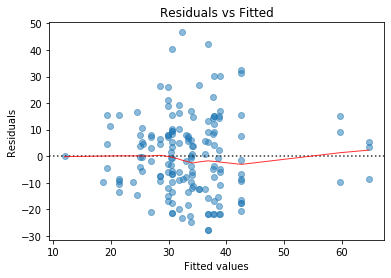

In [181]:
independence_test(lm)

This plot shows the residuals (errors) on the y-axis and the fitted values (predicted values) on the x-axis. We can see that plot has no pattern or in other words each goup has same variance, thus the points should look like a more of random points. The plot spoints out that the variances are approximately homogenous since the residuals are distributed approximately equally above and below zero.

### Shaprio-Wild test//qq plot to check the normal distribution of residuals

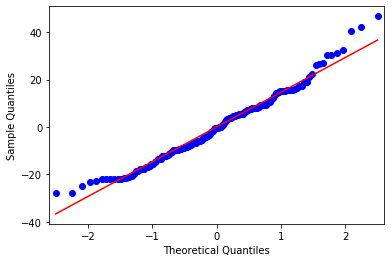

In [182]:
fig = sm.qqplot(lm.resid, line='s')
plt.show()

In [183]:
_, p = stats.shapiro(lm.resid)
print('p-values %.4f' % p)

p-values 0.0084


As the p-value < 0.0084 is non-significant, we fail to reject null hypothesis and conclude that residuals are normally distributed.

## Calcualate anova

As the assumptions of anova meet, now we can calculate it.

In [179]:
sm.stats.anova_lm(lm, type=3)

,df,sum_sq,mean_sq,F,PR(>F)
daytime,2.0,308.635740,154.317870,0.583483,0.559406
sleeping_time_groups,3.0,2751.439694,917.146565,3.467771,0.018178
sport_activity_groups,3.0,709.262381,236.420794,0.893917,0.446272
daytime:sleeping_time_groups,6.0,2576.735130,429.455855,1.623791,0.145511
daytime:sport_activity_groups,6.0,484.210222,80.701704,0.305137,0.933316
sleeping_time_groups:sport_activity_groups,9.0,3674.868645,408.318738,1.543871,0.139207
Residual,130.0,34382.041937,264.477246,NaN,NaN


Here we have calculated ANOVA response of daytime, sleeping time, sports activities number and their interaction on shopping duration. We only observed a significant difference in sleeping time group. Using this insight, companies can look for ways to target their customer concerning their daily life.

#### Interaction plot

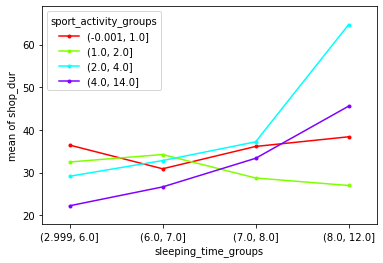

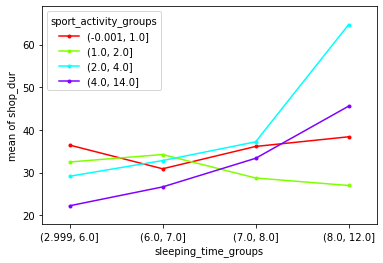

In [185]:
interaction_plot(data['sleeping_time_groups'], data['sport_activity_groups'], data['shop_dur'])

Interaction plot suggests that poeople sleeping more than 8 hours and actively participate in sports activities tended to spend more time in shopping.

## 9. shop_dur ~ ex_max_groups (ex_min_groups)

In [192]:
create_1cat_table(data, 'ex_max_groups', 'shop_dur')

+-----------------+-----+------------+------------+
| ex_max_groups   |   N |   shop_dur |   shop_dur |
|                 |     |       mean |        std |
+=================+=====+============+============+
| (106.0, 116.0]  |  41 |      30.66 |      12.63 |
+-----------------+-----+------------+------------+
| (116.0, 124.25] |  38 |      34.68 |      14.63 |
+-----------------+-----+------------+------------+
| (124.25, 148.0] |  40 |      33.52 |      18.97 |
+-----------------+-----+------------+------------+
| (69.999, 106.0] |  41 |      36.02 |      19.24 |
+-----------------+-----+------------+------------+


In [204]:
create_1cat_table(data, 'ex_min_groups', 'shop_dur')

+-----------------+-----+------------+------------+
| ex_min_groups   |   N |   shop_dur |   shop_dur |
|                 |     |       mean |        std |
+=================+=====+============+============+
| (43.999, 65.0]  |  44 |      36.39 |      17.73 |
+-----------------+-----+------------+------------+
| (65.0, 72.0]    |  38 |      31.24 |      15.72 |
+-----------------+-----+------------+------------+
| (72.0, 80.25]   |  38 |      33.92 |      15.04 |
+-----------------+-----+------------+------------+
| (80.25, 120.0]  |  40 |      32.9  |      17.68 |
+-----------------+-----+------------+------------+


As the distribution of ex_min_groups is very similar to the that of ex_max_grops, we won't calculate ANOVA assumptions again for it as well.

In [193]:
lm = smf.ols('shop_dur ~ ex_max_groups', data=data).fit()

### Independence of varaibles

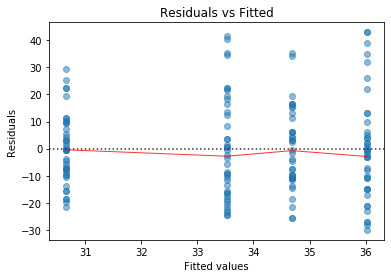

In [195]:
independence_test(lm)

This plot shows the residuals (errors) on the y-axis and the fitted values (predicted values) on the x-axis. We can see that plot is randomly distributed, this is independent.

### Homogenity test

In [196]:
groups = np.unique(data['ex_max_groups'])
print(groups)

['(106.0, 116.0]' '(116.0, 124.25]' '(124.25, 148.0]' '(69.999, 106.0]']


In [197]:
w, pvalue = stats.bartlett(data[data['ex_max_groups']==groups[0]]['shop_dur'], 
                           data[data['ex_max_groups']==groups[1]]['shop_dur'], 
                           data[data['ex_max_groups']==groups[2]]['shop_dur'], 
                           data[data['ex_max_groups']==groups[3]]['shop_dur'])
print('p-values %.4f' % p)

p-values 0.0084


This concludes that homogenity among groups holds.

### Shaprio-Wild//qq plot test to check the normal distribution of residuals

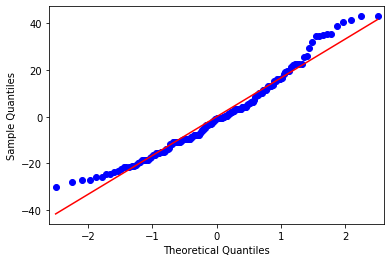

In [200]:
fig = sm.qqplot(lm.resid, line='s')
plt.show()

In [201]:
_, p = stats.shapiro(lm.resid)
print('p-values %.4f' % p)

p-values 0.0005


As the p-value < 0.0005 is non significant, we fail to reject null hypothesis and conclude that residuals are normally distributed.

### Calculate anova for both ex_max_groups and ex_min_groups

In [202]:
lm = smf.ols('shop_dur ~ ex_max_groups', data=data).fit()
sm.stats.anova_lm(lm, type=1)

,df,sum_sq,mean_sq,F,PR(>F)
ex_max_groups,3.0,638.813102,212.937701,0.750723,0.523488
Residual,156.0,44248.380648,283.643466,NaN,NaN


In [203]:
lm = smf.ols('shop_dur ~ ex_min_groups', data=data).fit()
sm.stats.anova_lm(lm, type=1)

,df,sum_sq,mean_sq,F,PR(>F)
ex_min_groups,3.0,575.530353,191.843451,0.675388,0.568359
Residual,156.0,44311.663397,284.049124,NaN,NaN


Annova test alone suggests that given ex_mag_groups and ex_min_groups don't show any different distribution on the response variable, thus not important for capturing necessary information.

## 10. shop_dur ~ max_time_groups (min_time_groups)

In [164]:
create_1cat_table(data, 'max_time_groups', 'shop_dur')

+-------------------+-----+------------+------------+
| max_time_groups   |   N |   shop_dur |   shop_dur |
|                   |     |       mean |        std |
+===================+=====+============+============+
| (0.999, 8.0]      |  43 |      22.86 |      15.62 |
+-------------------+-----+------------+------------+
| (16.5, 31.0]      |  41 |      34.12 |      11.02 |
+-------------------+-----+------------+------------+
| (31.0, 74.0]      |  39 |      51.38 |      12.81 |
+-------------------+-----+------------+------------+
| (8.0, 16.5]       |  37 |      27.22 |      10.66 |
+-------------------+-----+------------+------------+


In [165]:
create_1cat_table(data, 'min_time_groups', 'shop_dur')

+-------------------+-----+------------+------------+
| min_time_groups   |   N |   shop_dur |   shop_dur |
|                   |     |       mean |        std |
+===================+=====+============+============+
| (0.999, 6.0]      |  43 |      25.6  |      14.13 |
+-------------------+-----+------------+------------+
| (13.0, 23.0]      |  42 |      34.6  |      11.86 |
+-------------------+-----+------------+------------+
| (23.0, 150.0]     |  37 |      49.59 |      15.75 |
+-------------------+-----+------------+------------+
| (6.0, 13.0]       |  38 |      26.42 |      13.58 |
+-------------------+-----+------------+------------+


As the distribution of min_time_groups is very similar to the that of max_time_groups, we won't calculate ANOVA assumptions again for it as well.

In [206]:
lm = smf.ols('shop_dur ~ max_time_groups', data=data).fit()

### Independence of varaibles

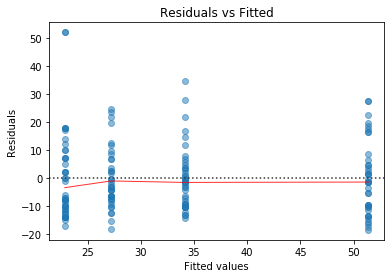

In [207]:
independence_test(lm)

This plot shows the residuals (errors) on the y-axis and the fitted values (predicted values) on the x-axis. We can see that plot is randomly distributed, this is independent.

### Homogenity test

In [209]:
groups = np.unique(data['max_time_groups'])
print(groups)

['(0.999, 8.0]' '(16.5, 31.0]' '(31.0, 74.0]' '(8.0, 16.5]']


In [210]:
w, pvalue = stats.bartlett(data[data['max_time_groups']==groups[0]]['shop_dur'], 
                           data[data['max_time_groups']==groups[1]]['shop_dur'], 
                           data[data['max_time_groups']==groups[2]]['shop_dur'], 
                           data[data['max_time_groups']==groups[3]]['shop_dur'])
print('p-values %.4f' % p)

p-values 0.0005


This concludes that homogenity among groups holds.

### Shaprio-Wild//qq plot test to check the normal distribution of residuals

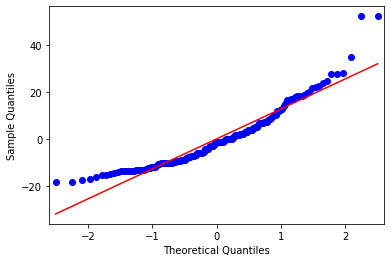

In [212]:
fig = sm.qqplot(lm.resid, line='s')
plt.show()

In [217]:
_, p = stats.shapiro(lm.resid)
print('p-values %.9f' % p)

p-values 0.000000015


As the p-value is non significant, we fail to reject null hypothesis and conclude that residuals are normally distributed.

### Calculate anova both for max_time_groups (min_time_groups)

In [219]:
lm = smf.ols('shop_dur ~ max_time_groups', data=data).fit()
sm.stats.anova_lm(lm, type=1)

,df,sum_sq,mean_sq,F,PR(>F)
max_time_groups,3.0,18812.139676,6270.713225,37.515982,2.603252e-18
Residual,156.0,26075.054074,167.147783,NaN,NaN


In [220]:
lm = smf.ols('shop_dur ~ min_time_groups', data=data).fit()
sm.stats.anova_lm(lm, type=1)

,df,sum_sq,mean_sq,F,PR(>F)
min_time_groups,3.0,14212.613556,4737.537852,24.093432,7.241940e-13
Residual,156.0,30674.580194,196.631924,NaN,NaN


Having very low F, both the ANOVA test shows us that max/min_time groups vary significantly from each other. Thus, it concludes that it's very important in understanding shopping duration trend. min/max_tim are variables stores the value for the time when participant reached minimum hear rate. This can be explained by the fact that customers mood (heart rate) is essential on understanding their shopping behaviour.